# Removing Trends - Lab

## Introduction

In this lab, you'll practice your detrending skills!

## Objectives

You will be able to:
* Learn how to remove trends and seasonality
* Use a log transformation to minimize non-stationarity
* Use rolling means to reduce non-stationarity
* Use differencing to reduce non-stationarity

## Detrending the Airpassenger data

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
# Import passengers.csv and set it as a time-series object. Plot the TS
df = pd.read_csv('passengers.csv')
df.Month = pd.to_datetime(df.Month, format='%Y/%m/%d')
df.set_index('Month', inplace=True)
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## Create a stationarity check

At this stage, we can use the code from previous labs to create a function `stationarity_check(ts)` that takes in a time series object and performs stationarity checks including rolling statistics and the Dickey Fuller test. 

We want the output of the function to:
- Plot the original time series along with the rolling mean and rolling standard deviation in one plot
- Output the results of the Dickey-Fuller test

In [10]:
# Create a function to check for the stationarity of a given timeseries using rolling stats and DF test
# Collect and package the code from previous lab
from statsmodels.tsa.stattools import adfuller
def stationarity_check(ts):
    rolmean = ts.rolling(window=8, center=False).mean()
    rolstd = ts.rolling(window=8, center=False).std()
    plt.figure(figsize=(16,8))
    plt.plot(ts, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling STD')
    plt.legend()
    plt.show()
    dftest = adfuller(ts['#Passengers'])
    # Extract and display test results in a user friendly manner
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    return None

Use your newly created function on the airpassenger data set.

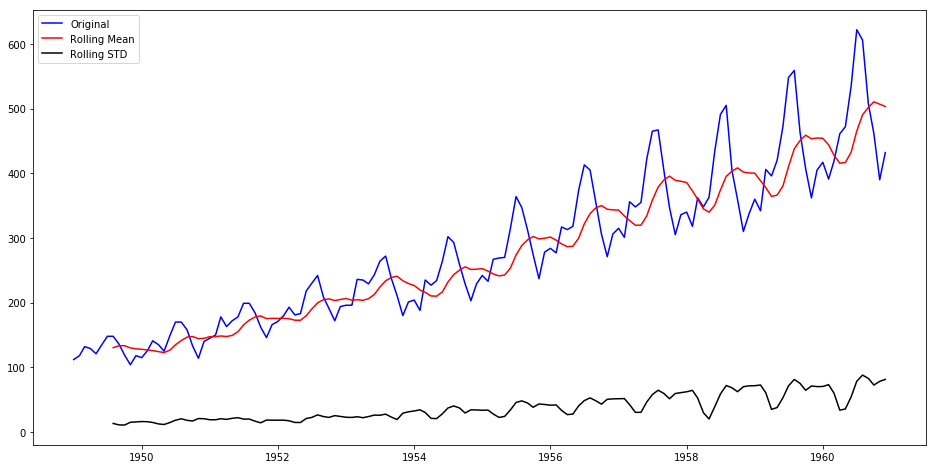

Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [11]:
stationarity_check(df)

## Perform a log() and sqrt() transform

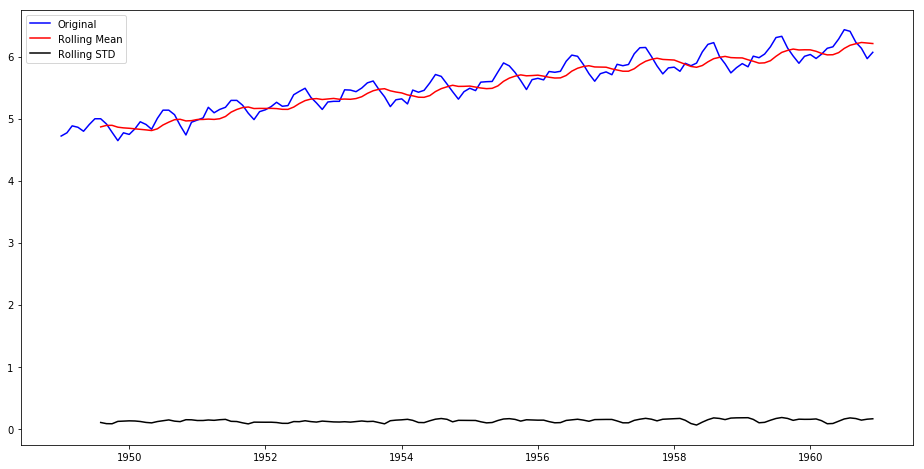

Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [12]:
# Log transform timeseries and compare with original to check the effect
df_log = np.log(df)
stationarity_check(df_log)

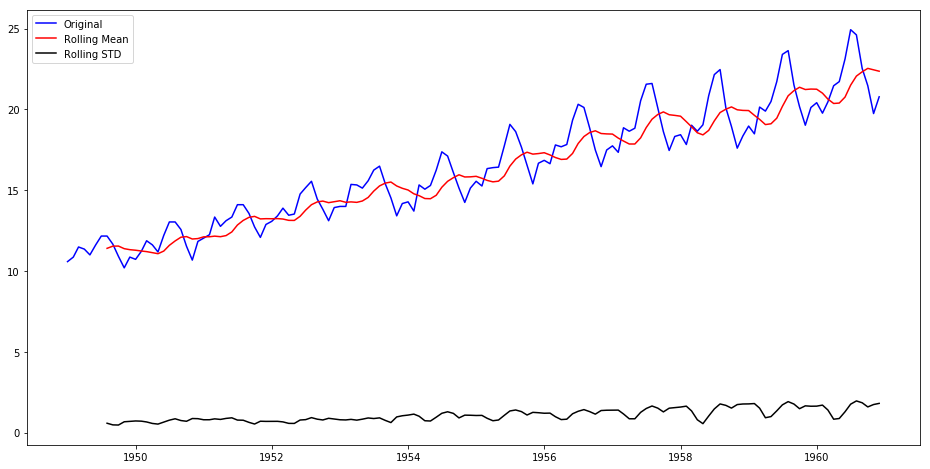

Test Statistic                  -0.345854
p-value                          0.918754
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [13]:
df_sqrt = np.sqrt(df)
stationarity_check(df_sqrt)

moving forward, let's keep working with the log transformed data before subtracting rolling mean, differencing, etc.

## Subtracting the rolling mean

Create a rolling mean using your log transformed time series, with a time window of 7. Plot the log-transformed time series and the rolling mean together.

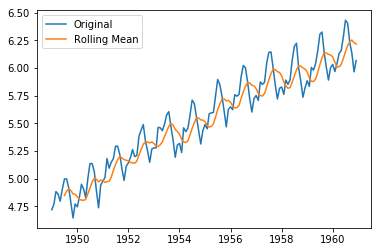

In [14]:
# your code here
rolmean = df_log.rolling(window=7, center=False).mean()
plt.plot(df_log, label='Original')
plt.plot(rolmean, label='Rolling Mean')
plt.legend()

Now, subtract the rolling mean from the time series, look at the 10 first elements of the result and plot the result.

In [16]:
# Subtract the moving average from the original data and check head for Nans
mean_diff = df_log - rolmean
mean_diff.head(10)

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
1949-06-01,NaN
1949-07-01,0.150059
1949-08-01,0.110242
1949-09-01,0.005404


In [17]:
# Drop the NaN values from timeseries calculated above
mean_diff.dropna(inplace=True)
mean_diff.head(10)

,#Passengers
Month,
1949-07-01,0.150059
1949-08-01,0.110242
1949-09-01,0.005404
1949-10-01,-0.113317
1949-11-01,-0.217275
1949-12-01,-0.087394
1950-01-01,-0.090241
1950-02-01,0.024099
1950-03-01,0.143499


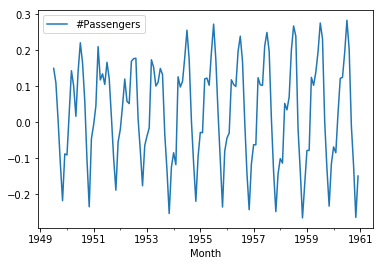

In [18]:
# Plot the result
mean_diff.plot()

Finally, use your function `check_stationarity` to see if this series is considered stationary!

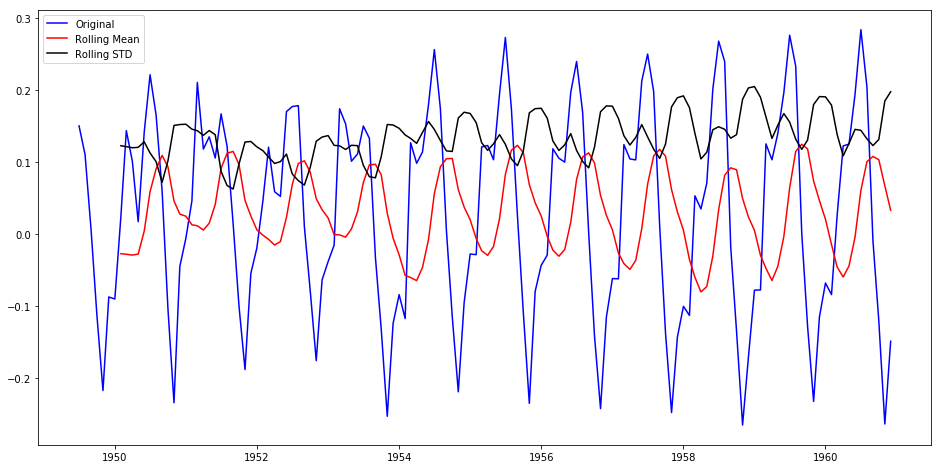

Test Statistic                  -2.348027
p-value                          0.156946
#Lags Used                      14.000000
Number of Observations Used    123.000000
Critical Value (1%)             -3.484667
Critical Value (5%)             -2.885340
Critical Value (10%)            -2.579463
dtype: float64


In [20]:
# Your code here
stationarity_check(mean_diff)

### Based on the visuals and on the Dickey-Fuller test, what do you conclude?


## Subtracting the weighted rolling mean

Repeat all the above for the *weighter* rolling mean. Start from the log-transformed data again. Compare the Dickey-Fuller Test results. What do you conclude?

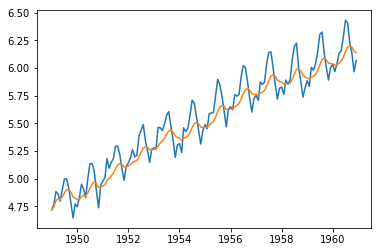

In [21]:
# Use Pandas ewma() to calculate Weighted Moving Average of ts_log
wrolmean = df_log.ewm(halflife=4).mean()
# Plot the original data with exp weighted average
plt.plot(df_log)
plt.plot(wrolmean)

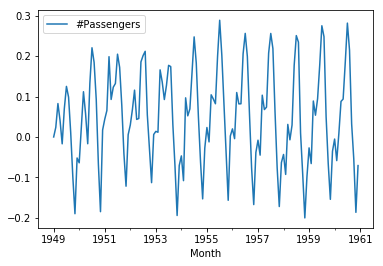

In [26]:
# Subtract the moving average from the original data and plot
wmean_diff = df_log - wrolmean
wmean_diff.plot()

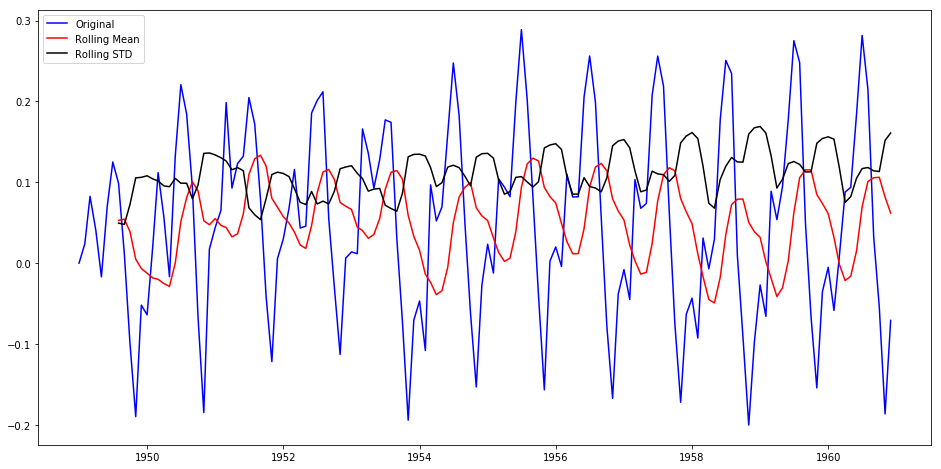

Test Statistic                  -3.297250
p-value                          0.015002
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [27]:
# do a stationarity check
stationarity_check(wmean_diff)

### Based on the visuals and on the Dickey-Fuller test, what do you conclude?


## Differencing

Using exponentially weighted moving averages, we seem to have removed the upward trend, but not the seasonality issue. Now use differencing to remove seasonality. Make sure you use the right amount of `periods`. Start from the log-transformed, exponentially weighted rolling mean-subtracted series.

After you differenced the series, run the `stationarity check` again.

In [31]:
# difference your data and look at the head
diff = wmean_diff.diff(periods=12)
diff.dropna(inplace=True)
diff.head(15)

,#Passengers
Month,
1950-01-01,-0.063907
1950-02-01,-0.001185
1950-03-01,0.029307
1950-04-01,0.016168
1950-05-01,0.000194
1950-06-01,0.062669
1950-07-01,0.095524
1950-08-01,0.085827
1950-09-01,0.081834


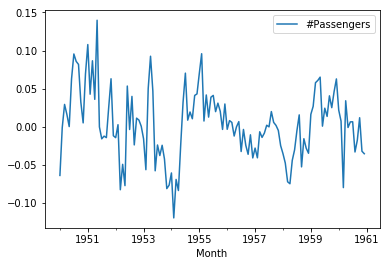

In [32]:
# plot your differenced time series
diff.plot()

In [16]:
# perform the stationarity check


### Your conclusion

## Summary 

In this lab, you learned how to make time series stationary through using log transforms, rolling means and differencing.